<a href="https://colab.research.google.com/github/CodeWithMayank-Py/ML-Models/blob/main/End_to_End_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import tensorflow_datasets as tfds
import os
import re
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import pickle
import glob
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
input_shape:tuple=299,299,3
(train, valid, test), metadata = tfds.load('food101', split=['train', 'validation[:50%]', 'validation[50%:]'], batch_size=32, shuffle_files=True, as_supervised=True,
                                           with_info=True)

In [ ]:
print('Dataset info:\n', metadata)

Dataset info:
 tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train'

In [ ]:
print('Element in training data:\n', train.element_spec)
print('Element in validation data:\n', valid.element_spec)
print('Element in testing data:\n', test.element_spec)
print('Training images counts:\n', train.cardinality()*32)
print('Validation images counts:\n', valid.cardinality()*32)
print('Testing images counts:\n', test.cardinality()*32)

Element in training data:
 (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Element in validation data:
 (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Element in testing data:
 (TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Training images counts:
 tf.Tensor(75776, shape=(), dtype=int64)
Validation images counts:
 tf.Tensor(12640, shape=(), dtype=int64)
Testing images counts:
 tf.Tensor(12640, shape=(), dtype=int64)


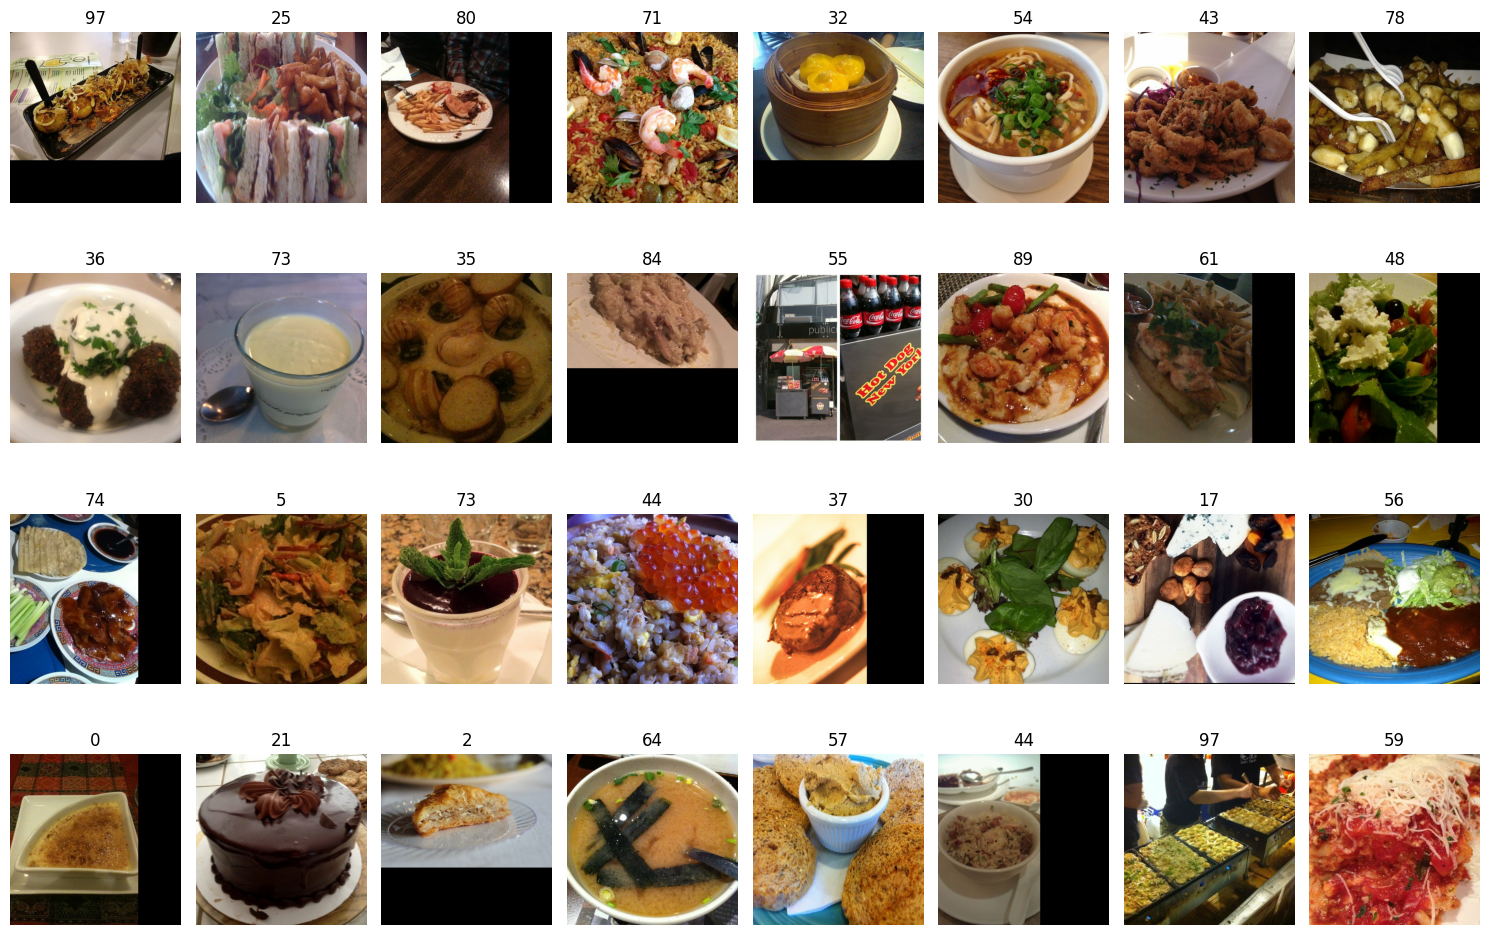

In [ ]:
# make plot data
for images, labels in train.take(1):break
images_to_plot : int=8*4
plt.figure(figsize=(15,10))
for index in range(images_to_plot):
  plt.subplot(4,8,index+1)
  plt.imshow(images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(labels[index].numpy())
plt.tight_layout()
plt.show()

In [ ]:
resizing_layer = tf.keras.layers.Resizing(height=299, width=299, interpolation="bilinear")
train=train.map(lambda images,labels: (resizing_layer(images),labels))
valid=valid.map(lambda images,labels: (resizing_layer(images),labels))
test=test.map(lambda images,labels: (resizing_layer(images),labels))

In [ ]:
# Make apply data augmentation

random_flip = tf.keras.layers.RandomFlip('horizontal_and_vertical', name='random_flip')
random_zoom = tf.keras.layers.RandomZoom(height_factor = 0.1, width_factor=0.1, name='random_zoom')
random_rotate = tf.keras.layers.RandomRotation(0.3, name='random_rotate')
random_brightness = tf.keras.layers.RandomBrightness(0.3, value_range=(0.0, 255.0), name='random_brightness')
augmentations = [random_flip, random_zoom, random_rotate, random_brightness]

# make apply augmentation on training data
for augmentation in augmentations:
  train = train.map(lambda images, labels: (augmentation(images), labels))

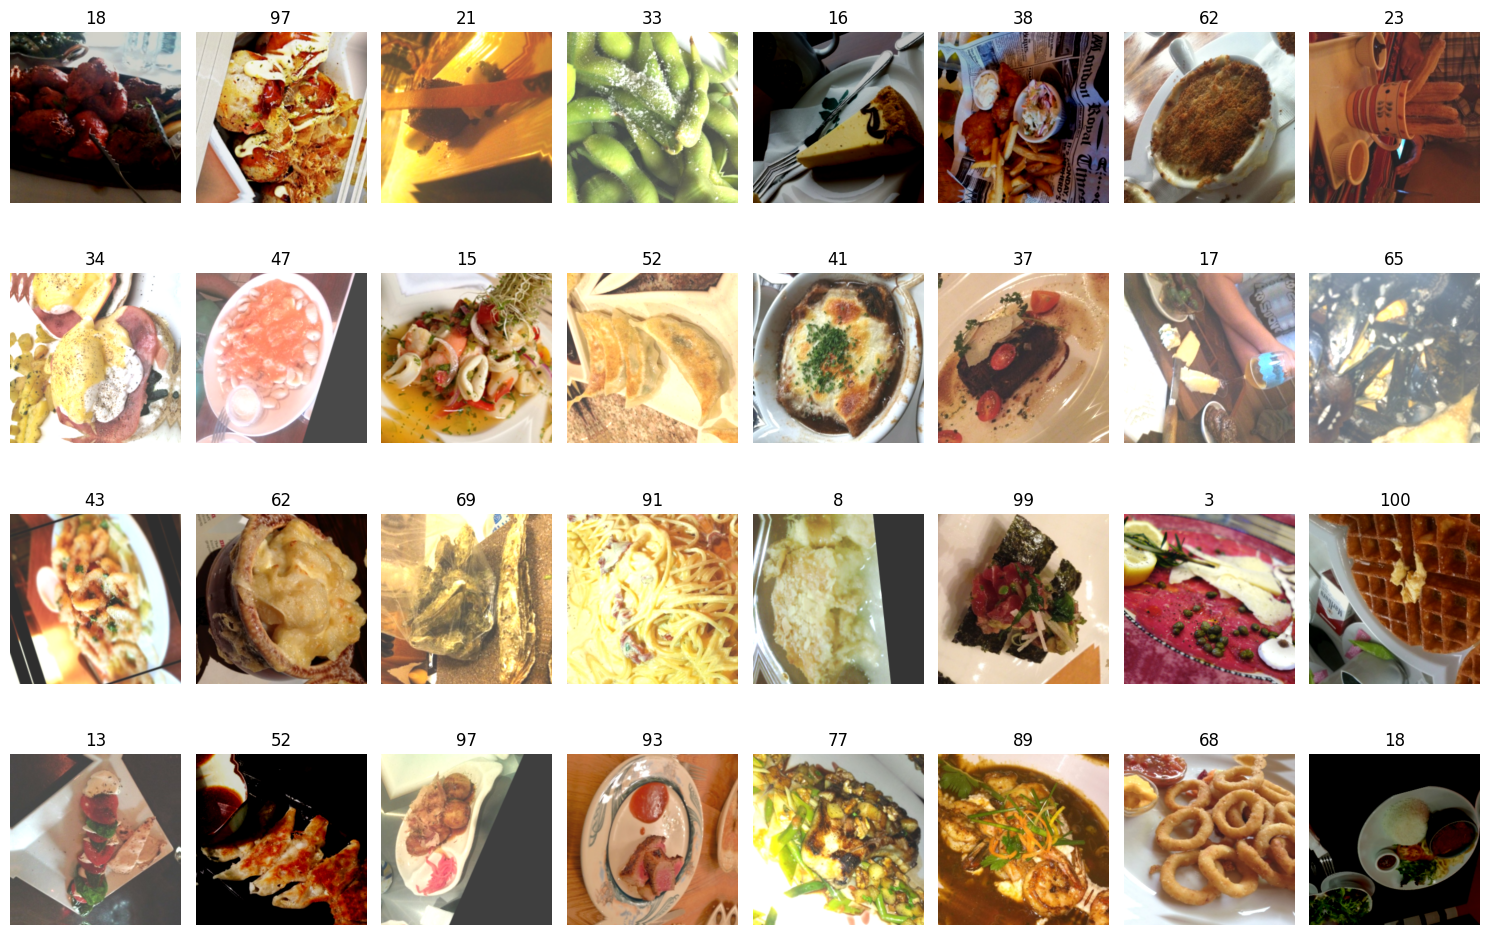

In [ ]:
# make plot data
for images, labels in train.take(1):break
images_to_plot : int=8*4
plt.figure(figsize=(15,10))
for index in range(images_to_plot):
  plt.subplot(4,8,index+1)
  plt.imshow(images[index].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(labels[index].numpy())
plt.tight_layout()
plt.show()

In [ ]:
print("Image Shape: ", images.shape)

Image Shape:  (32, 299, 299, 3)


In [ ]:
class ModelBuilder(object):

  ''' '''

  # make build Xception preprocessing Layer
  class XceptionPreProcessing(tf.keras.layers.Layer):

    ''' Xception preprocessing Layer Class '''

    # define layer call method
    def call(self,inputs)->tf.Tensor:

      ''' inputs (tf.Tensor) '''

      return tf.keras.applications.xception.preprocess_input(inputs)            # return preprocessed inputs


  def __init__(self,directory:str,input_shape:tuple,total_classes:int,
               fine_tuning:bool=False,
               name:str='custom_xception_classifier',
               )->tf.keras.Model:

    ''' '''

    self.directory:str=directory                                                # set model save directory
    if os.path.exists(directory):                                               # check if path exists then load model
       self.__load_model()                                                      # call model load method
    else:                                                                       # make build model
      # load pretrained X - for input shape without the model top layers (last dense output layer )
      xception_base=tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=input_shape)# make load xception base
      # Freeze the convolutional base (source): https://www.tensorflow.org/tutorials/images/transfer_learning#freeze_the_convolutional_base
      xception_base.trainable=fine_tuning                                       # make freeze pre-trained model layers (feature extraction)
      # Add a classification head (source): (https://www.tensorflow.org/tutorials/images/transfer_learning#add_a_classification_head
      # build as functional model (source): https://www.tensorflow.org/guide/keras/functional_api
      inputs=tf.keras.layers.Input(shape=input_shape,batch_size=None,name='inputs')# create input point for functional model by input layer
      #model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)# add rescaling layer # or custom preprocessing layer
      model_x=self.XceptionPreProcessing(name='preprocessing_00')(inputs)       # feed inputs to custom preprocessing layer
      model_x=xception_base(model_x)                                            # feed preprocessed outputs to xception
      model_x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool_02')(model_x)# feed xception outputs to Global Average Pooling layer
      outputs=tf.keras.layers.Dense(total_classes,activation='softmax')(model_x)# output (fully connected) layer
      self.model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_xception_classifier')# build functional model
      # compile the model (source): https://www.tensorflow.org/resources/models-datasets#compile_the_model
      # make compile model - low learning rate (as model is pretrained)---------
      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=tf.keras.metrics.SparseCategoricalAccuracy())
      # make early stopping (source): https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
      # tf.keras.callbacks.EarlyStopping: Stop training when a monitored metric has stopped improving.
      self.early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto',
                                                       restore_best_weights=True)
      # make model checkpoint (source): https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
      # tf.keras.callbacks.ModelCheckpoint: Callback to save the Keras model or model weights at some frequency.
      self.model_checkpoint=tf.keras.callbacks.ModelCheckpoint(directory,monitor='val_loss',verbose=0,save_best_only=True,
                                                               save_weights_only=True,mode='auto',save_freq='epoch',options=None,
                                                               initial_value_threshold=None)

    # set alias for model builder function
    self.compile=self.model.compile                                             # set alias for compile method
    self.summary=self.model.summary                                             # set alias for summary method
    self.model.orginalSave=self.model.save                                      # make alias for save model as have to be overwritten
    self.model.save=self.save                                                   # make overwrite save model (make update)


  # define method to save model
  def save(self,**kwargs)->None:

    ''' make save model '''

    # NOTE: overwrite and options have no uses but as called by model checkpoints, so need self.model.save in same order -
    #   `def save(self,filepath,overwrite:bool=True,options=None,compile:bool=True)->None:`
    #   source: https://github.com/keras-team/keras/blob/v2.14.0/keras/callbacks.py#L1580
    tf.keras.saving.save_model(self.model,self.directory,overwrite=True,save_format=None)# make save model
    with open(os.path.join(self.directory,'callback.stopEarly'),mode='wb+') as callback_file_object:# make save early stoping object
      pickle.dump(self.early_stop,callback_file_object)                         # make save early stoping file
    with open(os.path.join(self.directory,'callback.checkpoint'),mode='wb+') as callback_file_object:# make save model checkpoint object
      pickle.dump(self.model_checkpoint,callback_file_object)                   # make save model checkpoint


  # define method to load model
  def __load_model(self)->None:

    ''' to load model '''

    self.model=tf.keras.models.load_model(self.directory,custom_objects=self.XceptionPreProcessing,compile=True,safe_mode=True)# make load model
    with open(os.path.join(self.directory,'callback.stopEarly'),mode='rb+') as callback_file_object:# read early stopping file
      self.early_stop=pickle.load(callback_file_object)                         # make load early stoping object
    with open(os.path.join(self.directory,'callback.checkpoint'),mode='rb+') as callback_file_object:# read model checkpoint file
      self.model_checkpoint=pickle.load(callback_file_object)                   # make load model checkpoint object

  # define model to save history
  def saveHistory(self,history:dict)->None:

    ''' make save model history '''

    count:int=glob.glob(os.path.join(self.directory,'history_*'))               # get history count
    with open(os.path.join(self.directory,f'history_{str(count).zfill(3)}'),mode='wb+') as model_history_object:# make save history file
      pickle.dump(history,model_history_object)                                 # make save object


  # define method to load history
  def loadHistory(self,fileName:str=None)->dict:

    ''' make load and history object '''

    if isinstance(fileName,int):fileName=f'history_{str(fileName).zfill(3)}'    # make return file name is file count is given
    if fileName==None:                                                          # if file count is not give to load then load last save history
      history_files:list=glob.glob(os.path.join(self.directory,'history_*'))    # get list of all history file
      if len(history_files)==0:                                                 # if no previous saved history found
        raise RuntimeError(f'No previous history found to load at "{self.directory}"!')# raise error
      else:fileCount=sorted(history_files)[-1]                                  # get last saved history
    with open(os.path.join(self.directory,fileName),mode='rb+') as model_history_object:# make load history file
      return pickle.load(model_history_object)                                  # make return loaded save history


  # define method to make save combine history
  def saveJointHistory(self,history:dict,joinWithFileName:str=None)->None:

    ''' make save history joint with previous history '''

    history_files:list=glob.glob(os.path.join(self.directory,'history_all_*'))  # get list of all history file
    if isinstance(joinWithFileName,int):joinWithFileName=f'history_all_{str(joinWithFileName).zfill(3)}'# make return file name is file count is given
    if (joinWithFileName==None) and (len(history_files)==0):                    # if file name is not given and no last saved history found
      previous_history:dict=dict()                                              # make previous history to empty dict as no previous histry found
    elif (joinWithFileName==None) and (len(history_files)!=0):                  # else if file name is not give then make load last save history
      with open(os.path.join(self.directory,history_files[-1]),mode='rb+') as model_history_object:# make load history file
        previous_history:dict=pickle.load(model_history_object)                 # make load last save history
    else:                                                                       # if file name is given
      with open(os.path.join(self.directory,joinWithFileName),mode='rb+') as model_history_object:# make load history file
        previous_history:dict=pickle.load(model_history_object)                 # make load last save history
    # make join current history with previous history
    all_history:dict={f'history_{str(len(history_files)).zfill(3)}':history}    # make all history dictionary as dictionary with current history
    for key,value in previous_history.item():all_history[key]=value             # make add all previous history
    # make save all history
    with open(os.path.join(self.directory,f'history_all_{str(len(history_files)).zfill(3)}'),mode='wb+') as model_history_object:# make load history file
      pickle.dump(all_history,model_history_object)                             # make save all history


  # method to convert all history dictionary to pandas dataframe
  def allHistoryToDf(self,allHistory:dict,axis:int=0)->pd.DataFrame:

    ''' to convert all history to pandas dataframe '''

    return pd.concat(allHistory.values(),axis=axis,keys=allHistory.keys())      # make return all history as pandas dataframe